# Road/Lane Detection image segmentation approach

In [1]:
#Install requirements
%tensorflow_version 1.x
!pip install patchify
!pip install segmentation-models==1.0.1
!pip install 'h5py==2.10.0'

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 3.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


## Extracting images from KITTI dataset 



The dataset consists of multiple roads images and corresponding annotated images with pixel-wise semantic segmentation in 2 classes (Road and background). The total volume of the dataset is 289 pictures. \\
The RGB colors used for the semantic segmentation are:
- ROAD: (255 , 0 , 255) - Magenta
- BACKGROUND: (255 , 0 , 0) - Red 
- UNLABELED: (0 , 0 , 0) - Black

For this step you need to have all the dataset images uploaded in your google drive. 

In [25]:
# Imports and ROOT directory definition
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from os.path import join

import cv2
import numpy as np
import glob

from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt

import segmentation_models as sm
import tensorflow as tf
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()

root_directory = '/content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/' #Path to training images!
IMAGE_DATASET = '/content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/'

IMAGE_PATH = join(root_directory, IMAGE_DATASET)

Mounted at /content/drive


### Resizing and patching images of the dataset

In [3]:
#PATCHING ORIGINAL IMAGES
#***************************

# Patching process: 
patch_size = 256

image_dataset = []  

for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'image_2':   #Find image directory
        images = os.listdir(path)  #List of all image names in this subdirectory
        for image_name in sorted(images):  
            if image_name.endswith(".png"):   #Only read png images
                
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,image.height-SIZE_Y, SIZE_X, image.height))  #Crop form top left corner
                image = np.array(image)   

                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #no overlap
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                        
image_dataset = np.array(image_dataset)

In [4]:
#Now do the same as above for masks!
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'gt_image_2':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for mask_name in sorted(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,mask.height-SIZE_Y,SIZE_X, mask.height))  #Take cropped image from left edge
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask)

mask_dataset =  np.array(mask_dataset)

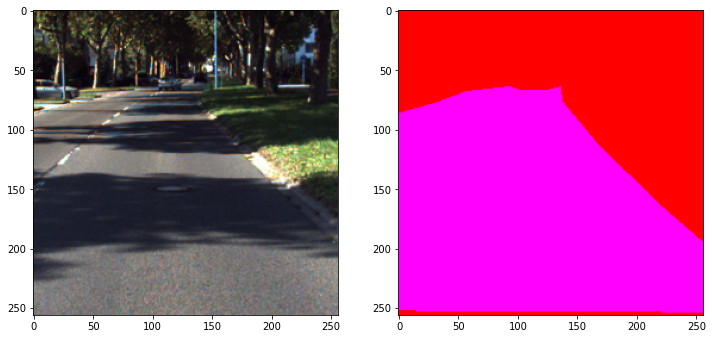

In [10]:
#Random check, to see if mask correspond to image. (Play a few times)
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [11]:
#Mask to labels
Road = np.array([255,0,255]) 
Back = np.array([255,0,0])
Unlabeled = np.array([0,0, 0])

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Road,axis=-1)] = 0
    label_seg [np.all(label==Back,axis=-1)] = 1
    label_seg [np.all(label==Unlabeled,axis=-1)] = 1 #The unlabeled color will be also part of the background class
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i]) #reeplace rgb vector by an unique int
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels)) #In this case, just 2 classes Road and background

Unique labels in label dataset are:  [0 1]


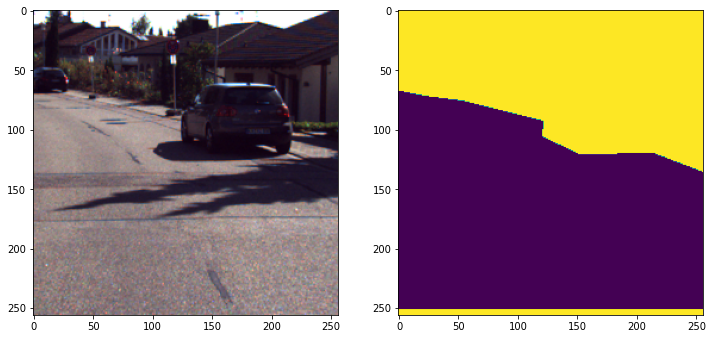

In [15]:
#Another check, view few mages (Check if mask correspond to image)
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

## Training process

In [19]:
#INFO for all models - (RUN THIS SECTION EVERY TIME no matter if you want to load a saved model or train a new one)
n_classes = len(np.unique(labels))

from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


### MODEL 1 - UNET STRUCTURE

In [20]:
# UNET! PART 1 - (RUN THIS SECTION IF: you want to train a new UNET model or want to load a saved UNET model)

#MODEL 1 - UNET
#**************************************
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def jacard_coef(y_true, y_pred): #Metric for evaluating the model, complementary to the accuracy (Based on IoU)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



In [ ]:
# UNET! PART 2 (RUN THIS SECTION JUST if you want to try a new UNET model changing hyperparameters and losses, otherwise go to "load model")

weights = [0.5, 0.5]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

#**********************************************************************************************************
def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #model.summary()
    
    return model
#***********************************************************************************************************

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

#Tests to make UNET:
##*************************************************************
#Minimax scaler
#With binary cross and adam: loss: 0.0213 - accuracy: 0.9903 - jacard_coef: 0.9734 - val_loss: 0.1939 - val_accuracy: 0.9651 - val_jacard_coef: 0.9242
#With bin focal loss and adam: loss: 0.0029 - accuracy: 0.9898 - jacard_coef: 0.9508 - val_loss: 0.0332 - val_accuracy: 0.9628 - val_jacard_coef: 0.8983
#With dice loss and Adam (equal weights) 60 epochs: loss: 0.5268 - accuracy: 0.9548 - jacard_coef: 0.9141 - val_loss: 0.5272 - val_accuracy: 0.9554 - val_jacard_coef: 0.9139
#With dice loss and Adam (diff weights 0.7R/0.3B): loss: 0.5346 - accuracy: 0.9491 - jacard_coef: 0.9037 - val_loss: 0.5342 - val_accuracy: 0.9518 - val_jacard_coef: 0.9070 
#With total loss and Adam (equal weights): loss: 0.5086 - accuracy: 0.9905 - jacard_coef: 0.9777 - val_loss: 0.5445 - val_accuracy: 0.9653 - val_jacard_coef: 0.9279
#With total loss and Adam (diff weights 0.7R/0.3B): loss: 0.5137 - accuracy: 0.9869 - jacard_coef: 0.9699 - val_loss: 0.5436 - val_accuracy: 0.9660 - val_jacard_coef: 0.9300

#standard scaler (2 classes) 
#bin cross entropy y adam: loss: 0.0237 - accuracy: 0.9892 - jacard_coef: 0.9705 - val_loss: 0.1684 - val_accuracy: 0.9652 - val_jacard_coef: 0.9235
#total loss adam eq weights: loss: 0.5127 - accuracy: 0.9900 - jacard_coef: 0.9717 - val_loss: 0.6132 - val_accuracy: 0.9596 - val_jacard_coef: 0.9100
#***************************************************************



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 2320        dropout_10[0][0]                 
____________________________________________________________________________________________

In [18]:
# IF you train a new UNET model, save it in your drive with a corresponding name
model.save('/content/drive/MyDrive/VP_project/KITTI/models/road_detection_unet_100epochs_adam_totalLosseq_Standardscaler(binaryclass).h5')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-4731436f1198>", line 1, in <module>
    model.save('/content/drive/MyDrive/VP_project/KITTI/models/road_detection_unet_100epochs_adam_totalLosseq_Standardscaler(binaryclass).h5')
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(

NameError: ignored

### Pretrained models - (You can use RESNET for example)

In [ ]:
#PRETRAINED MODElS (RUN THIS SECTION JUST IF: You want to try a new pretrained model)
#TRY ANOTHER MODEL - WITH PRETRINED WEIGHTS

from keras import backend as K
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

weights = [0.7, 0.3]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

metrics=['accuracy', jacard_coef]

# compile keras model with defined optimizer, loss and metrics
model_resnet_backbone.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

#TESTS!
#Minimax scaler and RESNET34
#bin cross entropy y adam: loss: 0.0194 - accuracy: 0.9911 - jacard_coef: 0.9756 - val_loss: 0.0862 - val_accuracy: 0.9779 - val_jacard_coef: 0.9502
#total loss adam eq weights: loss: 0.5085 - accuracy: 0.9905 - jacard_coef: 0.9776 - val_loss: 0.5199 - val_accuracy: 0.9817 - val_jacard_coef: 0.9618
#With total loss and Adam (diff weights 0.7R/0.3B): loss: 0.5103 - accuracy: 0.9898 - jacard_coef: 0.9763 - val_loss: 0.5244 - val_accuracy: 0.9804 - val_jacard_coef: 0.9565

#EFNET7
#binary cross entroy and adam: N/A


71892992/71892840 [==============================] - 8s 0us/step
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1296        input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
__________________________

In [ ]:
#Use this line to save your pretrained running model
model.save('/content/drive/MyDrive/VP_project/KITTI/models/road_detection_effnet4_100epochs_adam_binCross(binaryclass).h5')

### Training history and validation

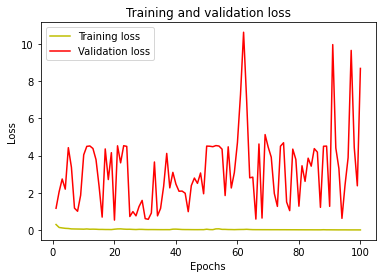

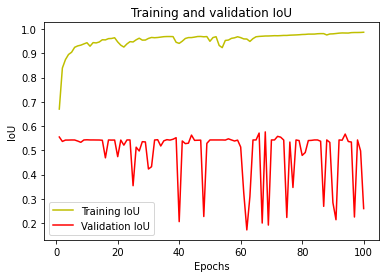

In [ ]:
#USE THIS SECTION IF YOU TRAINED A NEW MODEL
#plot the training and validation accuracy and loss at each epoch
history = history2 #Change depending on the model (RESNET history2 - UNET history1)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()



### Load models already saved for testing and comparing!

In [28]:
#Only RUN for loading models!
from keras.models import load_model
#model = load_model("/content/drive/MyDrive/VP_project/KITTI/models/1_road_detection_unet_100epochs_adam_BinaryCross",
#                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                   'jacard_coef':jacard_coef})

model = load_model('/content/drive/MyDrive/VP_project/KITTI/Models(final)/1_road_detection_unet_100epochs_adam_BinaryCross.h5',
                   custom_objects={'jacard_coef':jacard_coef})

#Models available (Check the model name in the folder inside the GitHub 'Models'):
#With Minimax scaler and UNET!
#1. Binary cross-entropy and adam opt (100 epochs)
#2. With binary focal loss and adam opt (100 epochs)
#3. With dice loss and Adam opt (equal weights) (60 epochs)
#4. With dice loss and Adam (diff weights 0.7R/0.3B)
#5. With total loss and Adam (equal weights)
#6. With total loss and Adam (diff weights 0.7R/0.3B)

#With standard scaler and UNET! (2 classes) 
#7. Binary cross-entropy and adam opt (100 epochs)
#8. Total loss and adam opt (equal weights)

#With Minimax scaler and RESNET34!
#Minimax scaler (2 classes)
#9. Binary cross entropy and adam (100 epochs) 
#10. Total loss and adam eq weights (100 epochs)
#11. With total loss and Adam (diff weights 0.7R/0.3B)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Results - Ground truth vs Predictions

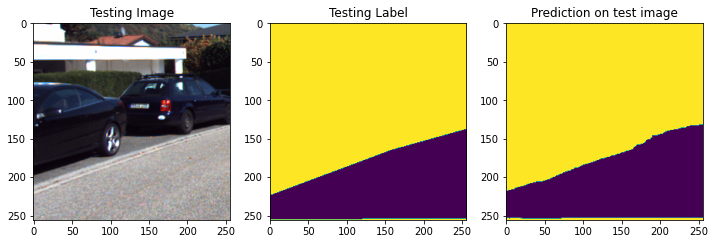

In [30]:
#Predictions
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
